In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import winsound
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import GradientBoostingClassifier
from mlxtend.classifier import EnsembleVoteClassifier
from sklearn import metrics
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.model_selection import GridSearchCV as GSCV
from itertools import combinations

def analyze_feature(data,feature):
    """Analyzes each category of each categorical feature and dumps results in a table"""
    counts = data[feature].value_counts()
    bins = data[feature].unique().tolist()
    table = []
    for n, category in enumerate(bins):
        filtered_data = data[data[feature]==category].loc[:,'default']
        defaulted_1 = filtered_data[filtered_data==1].value_counts()[1] #Bad
        defaulted_2 = len(filtered_data)-defaulted_1 #Good
        default_ratio = defaulted_1/float(len(filtered_data))
        adj_ratio = (0.3-default_ratio)*100 #300 out of 1000 is defaults (bad) which is 3/10
        table.append([feature, category, adj_ratio, counts[bins[n]], defaulted_1, defaulted_2, default_ratio])
    table = pd.DataFrame(data=table,columns=['feature','cat','adj_ratio','count','yes','no','def_ratio'])
    return table

def decision_tree_max_depth_assessment(max_max_depth, feature_names, X_train, y_train, X_test, y_test):
    """Plots feature importances and accuracy score of a gini and enptropy decision tree clf across a range of depths"""
    fig = plt.figure(figsize=[25,5])
    ax2 = fig.add_subplot(131); plt.title("Gini")
    ax3 = fig.add_subplot(132); plt.title("Entropy")
    ax1 = fig.add_subplot(133); plt.ylabel("Accuracy")
    plt.yticks(np.arange(0.66,0.80,0.004))
    plt.xticks(np.arange(1,max_max_depth,1))
    for criteria in ('gini','entropy'):
        test_accuracy = []; imps = []
        for depth in range(1,max_max_depth):
            tree = DecisionTreeClassifier(max_depth=depth, criterion=criteria, random_state=2017).fit(X_train,y_train)
            test_accuracy.append(tree.score(X_test, y_test))
            fea = tree.feature_importances_.tolist()
            max0, min0 = max(fea), min(fea)
            fea = list(map((lambda x: (x-min0)/(max0-min0)),fea))
            imps.append(fea)
        fea_imp = pd.DataFrame(data=imps, columns=feature_names, index=range(1,max_depth))
        axes = ax2 if criteria == 'gini' else ax3
        sns.heatmap(fea_imp.T, annot=False, fmt=".2f", square=True, cmap='binary',ax=axes, cbar=False,annot_kws={"size": 8})
        ax1.plot(range(1,max_depth),test_accuracy,'--.',label=criteria)
    ax1.grid(True)
    ax1.legend(loc='best')
    return plt.show()

def do_my_BORING_exhaustive_grid_search_cv(params, models, model_names, X_train, y_train, heads=0, do=(0,1,2,3,4,5)):
    """Carries out an unintelligent exhaustive grid search cv for all models specified in do and returns best_models, best_params and detailed GSCV results"""
    best_models = []
    best_params = []
    xGSCV_results = []
    
    for count,model in enumerate(models):
        # In case I do not want to do the search again for only some models
        if count in do:
            
            winsound.Beep(1800,150) # To let me know it started a model
            
            grid_search = GSCV(model, params[count], n_jobs=8, cv=8, scoring='roc_auc', return_train_score=False).fit(X_train, y_train)
            print("{} {:.4f} {}".format(model_names[count], grid_search.best_score_, grid_search.best_params_))
            best_models.append(grid_search.best_estimator_)
            best_params.append(grid_search.best_params_)
            
            # Saving all grid search results
            results = pd.DataFrame(grid_search.cv_results_).sort_values(by=['rank_test_score'],axis=0)
            results.reset_index(inplace = True, drop=True)
            a = results[['mean_test_score','std_test_score']]
            results.drop(['mean_test_score','std_test_score','params','mean_fit_time','mean_score_time','std_fit_time','std_score_time'], axis = 1, inplace = True)
            results = pd.concat([a,results],axis=1)
            xGSCV_results.append(results)
            if heads>0: display(results.head(heads).T)
            
            winsound.Beep(1500,250) # To let me know it finished a model
            
    winsound.Beep(2000,500) # To let me know its completely done
    return best_models, best_params, xGSCV_results

def generate_all_voting_combinations(votable_models, models, X_train, y_train, names):
    """Generates and trains all soft and hard voting ensemble combinations"""
    all_models = []
    all_names = []
    
    for count in range(2,len(votable_models)+1):
        combos = [combo for combo in combinations(votable_models,count)]# Generaing combinations
        
        for combo in combos:# Generating soft voting models
            soft_voter = EnsembleVoteClassifier(clfs=[models[i] for i in combo], voting='soft', refit=False).fit(X_train, y_train)
            name = 'soft('+', '.join([names[letter] for letter in combo])+')'
            all_models.append(soft_voter)
            all_names.append(name)
            
            if count % 2 == 1:# If number of models is odd generate a hard voting model as well
                hard_voter = EnsembleVoteClassifier(clfs=[models[i] for i in combo], voting='hard', refit=False).fit(X_train, y_train)
                name = 'hard('+', '.join([names[letter] for letter in combo])+')'
                all_models.append(soft_voter)
                all_names.append(name)
                
    return all_models, all_names

def find_optimal_thresholds_test_and_gen_reports(models, model_names, X_train, X_test, y_train, y_test, predict_proba_exceptions):
    """Finds optimal thresholds, tests and generates 3 reports"""
    reports = []
    nm_preds = pd.DataFrame(data=y_test,columns=['Actual'])# Report 2: Non-optimized model predictions
    om_preds = pd.DataFrame(data=y_test,columns=['Actual'])# Retorn 3: Optimized model predictions
    
    for count, model in enumerate(models):
        
        winsound.Beep(3000,50) # To let me know it started a model
        
        # Non-optimized model testing
        y_pred_test = model.predict(X_test)
        nm_pred = pd.DataFrame(data=y_pred_test, columns=[model_names[count]])
        nm_preds = pd.concat([nm_preds, nm_pred], axis=1)
        
        # Finding optimal ROC Threshold
        if count not in predict_proba_exceptions: # If model has predict_proba_ method
            y_pred_prob = model.predict_proba(X_train)[:, 1]
            y_pred_prob_test = model.predict_proba(X_test)[:, 1]
        else:
            y_pred_prob = model.decision_function(X_train)
            y_pred_prob_test = model.decision_function(X_test)
        fpr, tpr, threshold = metrics.roc_curve(y_train, y_pred_prob)
        i = np.arange(len(tpr))
        roc = pd.DataFrame({'tf':pd.Series(tpr-(1-fpr), index=i), 'threshold':pd.Series(threshold,index=i)})
        roc_t = roc.iloc[(roc.tf-0).abs().argsort()[:1]]
        optimal_threshold = list(roc_t['threshold'])
        
        # Optimized model testing
        y_pred_optimal_test = np.where(y_pred_prob_test >= optimal_threshold, 1, 0) # optimizing predictions
        om_pred = pd.DataFrame(data=y_pred_optimal_test, columns=[model_names[count]])
        om_preds = pd.concat([om_preds,om_pred],axis=1)
        
        # Generating confusion matric
        ncm = metrics.confusion_matrix(y_test, y_pred_test)
        ocm = metrics.confusion_matrix(y_test, y_pred_optimal_test)
        
        # Generating non-optimized and optimized model accuracy and error type report
        report = [model_names[count], optimal_threshold[0],
                  metrics.accuracy_score(y_test, y_pred_optimal_test)*100, ocm[0,1], ocm[1,0],
                  metrics.accuracy_score(y_test, y_pred_test)*100, ncm[0,1], ncm[1,0]]
        reports.append(report)
        
    winsound.Beep(1500,75) # To let me know it finished all models
    
    # Report 1: Accuracy and Error Type report
    AETR = pd.DataFrame(data=reports, columns=['Model', 'threshold', 'oACC', 'o2', 'o1', 'nACC', 'n2', 'n1'])
    return AETR, nm_preds, om_preds

def show_feature_importances(feature_names, models, xlim=0.27):
    """Plots feature importances for RFC, GBC and ADA"""
    n_features = len(feature_names)
    fig = plt.figure(figsize=[15,15])
    ax1 = fig.add_subplot(311); plt.yticks(range(n_features), feature_names); plt.title('RFC'); plt.xlim((0, xlim)); plt.xticks(np.arange(0, xlim, 0.02))
    ax2 = fig.add_subplot(312); plt.yticks(range(n_features), feature_names); plt.title('GBC'); plt.xlim((0, xlim)); plt.xticks(np.arange(0, xlim, 0.02))
    ax3 = fig.add_subplot(313); plt.yticks(range(n_features), feature_names); plt.title('ADA'); plt.xlim((0, xlim)); plt.xticks(np.arange(0, xlim, 0.02))
    ax1.barh(range(n_features), models[0].feature_importances_, align='center', color='r'); ax1.grid(True)
    ax2.barh(range(n_features), models[1].feature_importances_, align='center', color='g'); ax2.grid(True)
    ax3.barh(range(n_features), models[2].feature_importances_, align='center', color='b'); ax3.grid(True)
    return plt.show()

def show_Accuracy_Error_Type_Report_plots(final_model_names, report, t1e=(6.5, 22.5, 0.5), t2e=(5, 18.5, 0.5), acc=(70.5, 80, 0.5)):
    """Plots the AETR report results thereby showing a comparison between non-optimized models and optimized models"""
    n_models = len(final_model_names)
    fig = plt.figure(figsize=[30,50])
    ax1 = fig.add_subplot(325); plt.yticks(range(n_models), report['Model']); plt.title('Non Type 1 Error'); plt.xticks(np.arange(t1e[0], t1e[1], t1e[2])); plt.xlim((t1e[0], t1e[1]))
    ax2 = fig.add_subplot(323); plt.yticks(range(n_models), report['Model']); plt.title('Non Type 2 Error'); plt.xticks(np.arange(t2e[0], t2e[1], t2e[2])); plt.xlim((t2e[0], t2e[1]))
    ax3 = fig.add_subplot(326); plt.yticks(range(n_models), report['Model']); plt.title('Opt Type 1 Error'); plt.xticks(np.arange(t1e[0], t1e[1], t1e[2])); plt.xlim((t1e[0], t1e[1]))
    ax4 = fig.add_subplot(324); plt.yticks(range(n_models), report['Model']); plt.title('Opt Type 2 Error'); plt.xticks(np.arange(t2e[0], t2e[1], t2e[2])); plt.xlim((t2e[0], t2e[1]))
    ax5 = fig.add_subplot(321); plt.yticks(range(n_models), report['Model']); plt.title('Non Test Accuracy'); plt.xticks(np.arange(acc[0], acc[1], acc[2])); plt.xlim((acc[0], acc[1]))
    ax6 = fig.add_subplot(322); plt.yticks(range(n_models), report['Model']); plt.title('Opt Test Accuracy'); plt.xticks(np.arange(acc[0], acc[1], acc[2])); plt.xlim((acc[0], acc[1]))
    ax1.barh(range(n_models), report['n1'], align='center',color='r'); ax1.grid(True)
    ax2.barh(range(n_models), report['n2'], align='center',color='g'); ax2.grid(True)
    ax3.barh(range(n_models), report['o1'], align='center',color='r'); ax3.grid(True)
    ax4.barh(range(n_models), report['o2'], align='center',color='g'); ax4.grid(True)
    ax5.barh(range(n_models), report['nACC'], align='center',color='b'); ax5.grid(True)
    ax6.barh(range(n_models), report['oACC'], align='center',color='b'); ax6.grid(True)
    return plt.show()

def main_function(X, y, feature_names, models, model_names, params, GSCV_detail=0, do=(0,1,2,3,4,5), show=True):
    """Splits the data, conducts grid search and then optimizes models if hyper parameter tuning is over"""
    # Creating train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=2017)

    if show == True:
        # Plotting stand alone decision tree performance with varying max_depths and criterias
        decision_tree_max_depth_assessment(22, feature_names, X_train, y_train, X_test, y_test)

    # Grid search
    best_models, best_params, xGSCV_results = do_my_BORING_exhaustive_grid_search_cv(params, models, model_names, X_train, y_train, heads=GSCV_detail, do=(0,1,2,3,4,5))
    
    if GSCV_detail == 0:
        # Creating all possible hard and soft voting ensemble combinations
        votable_models = [0,1,2,3,4] # Linear Support Vector Classifier does have predict_proba_
        en_voting_models, en_voting_names = generate_all_voting_combinations(votable_models, best_models, X_train, y_train, ['R','G','A','B','L'])
        final_models = best_models + en_voting_models
        final_model_names = model_names + en_voting_names

        # Threshold optimization and testing
        AETR, nm_preds, om_preds = find_optimal_thresholds_test_and_gen_reports(final_models, final_model_names, X_train, X_test, y_train, y_test, (5,))

        # Converting columns in AETR to percentages
        report = AETR.copy()
        report[['o2','o1','n2','n1']] = report[['o2','o1','n2','n1']].apply(lambda x:x*0.4)

        if show == True:
            # Showing feature impotances for RFC, GBC and ADA
            show_feature_importances(feature_names, final_models, 0.27)

            # Showing performance                                              Type 1 Error      Type2 Error      Accuracy
            show_Accuracy_Error_Type_Report_plots(final_model_names, report, (6.5, 22.5, 0.5), (5, 18.5, 0.5), (70.5, 80, 0.5))

        winsound.Beep(70,1000);winsound.Beep(2900,600);winsound.Beep(1000,250);winsound.Beep(500,400)
        return [best_models, best_params, xGSCV_results, AETR, nm_preds, om_preds, report]
    else:
        print '>>> [ T U N I N G    D O N E ]'
        winsound.Beep(70,1000);winsound.Beep(2900,600);winsound.Beep(1000,250);winsound.Beep(500,400)
        return [best_models, best_params, xGSCV_results]

#################################################################################
###   G L O B A L   S T U F F ###################################################
#################################################################################

# Importing the data
raw = pd.read_csv('credit2.csv')

# Editting class labels: 0 is bad and 1 is good
y = [0 if label == 1 else 1 for label in raw['default'].values]

# Models and their 'base' settings
RFC = RandomForestClassifier(max_features='sqrt', bootstrap=False)
GBC = GradientBoostingClassifier(max_features=None)
ADA = AdaBoostClassifier()
BGC = BaggingClassifier()
LRC = LogisticRegression(solver='liblinear', max_iter=1000)
VEC = LinearSVC(dual=False)
models = [RFC,GBC,ADA,BGC,LRC,VEC]
model_names = ['RFC','GBC','ADA','BGC','LRC','VEC']

# Pandas display settings
pd.options.display.max_colwidth = 200
pd.options.display.width = 400

winsound.Beep(1800,50); winsound.Beep(1500,75); winsound.Beep(1200,100)

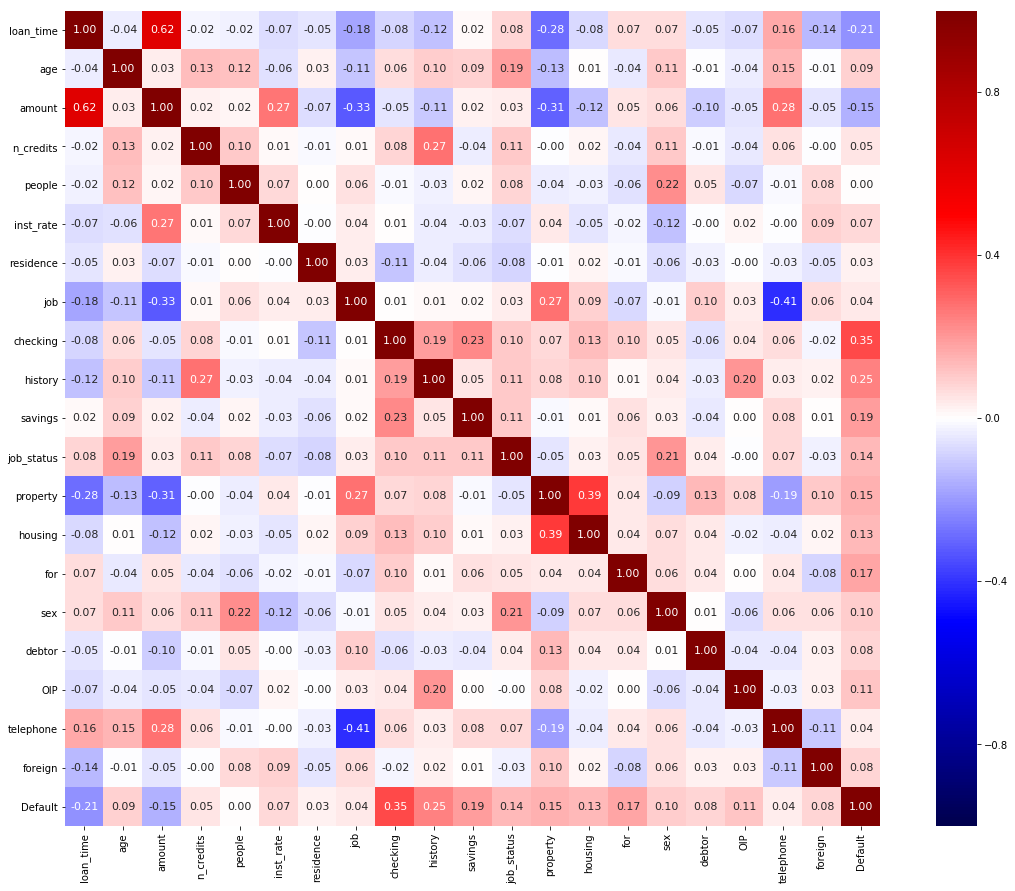

In [11]:
#################################################################################
###   D A T A S E T   1   A N D   2   ###   C O M M O N   P R E P S   ###########
#################################################################################

# Numerical features
NU_fe = raw[['loan_time', 'age', 'amount']]

# Stating which features are being treated as ordinal features
categorical_features = ['n_credits', 'people', 'inst_rate', 'residence', 'job', 'checking', 'history', 'savings',
                        'job_status', 'property', 'housing', 'for', 'sex', 'debtor', 'OIP', 'telephone', 'foreign']
OD_fe = pd.DataFrame(columns=categorical_features)

# Analysing each categorical feature and their respective categories 
for feature in categorical_features:
    data = analyze_feature(raw,feature)
    data = data.sort_values(by=['def_ratio'], axis=0,ascending=False).reset_index(drop=True)
    #display(data)

# Dictionary consisting custom encoding keys for each category based and results on ****line 17****
dicts = [{4:-3.3,1:-1.6,2:2.4,3:8.6}, # ....................................................................................................n_credits
         {1:-0.1,2:0.3}, # .................................................................................................................people
         {4:-3.3,3:1.4,2:3.2,1:5}, # .......................................................................................................inst_rate
         {2:-1.5,4:0,3:1.1,1:2.3}, # .......................................................................................................residence
         {'man/self-em/HQ/off':-4.5,'unemp / unskill (non-res)':-1.8,'skilled / official':0.5,'unskilled (resident)':2}, # .................job
         {'< 0':-19.3,'0 to 200':-9,'> 201':7.8,'none':18.3}, # ............................................................................checking
         {'fully repaid':-32.5,'fully repaid here':-27.1,'repaid':-1.8,'delayed':-1.8,'critical':12.9}, # ..................................history
         {'<100':-6,'101 to 500':-3,'unk_nil':12.5,'501 to 1000':12.5,'>1000':17.5}, # .....................................................savings
         {'less than 1':-10.7,'unemployed':-7.1,'1 to less than 4':-0.68,'more than 7':4.7,'4 to less than 7':7.6}, # ......................job_status
         {'UNK/None':-13.5,'Car/Other':-0.65,'BSSA/Life':-0.65,'real estate':8.7}, # .......................................................property
         {'own':1,'free':-1,'rent':-1}, # ..................................................................................................housing
         {'edu':-14,'car_new':-8,'repairs':-6.4,'business':-5,'dom_app':-3.3,'fur_equ':-2,'rad_tel':7.8,'car_used':10.9,'retain':18.9}, # ..for
         {'male_ds':-10,'female':-5,'male_mw':2.8,'male_single':3.4}, # ....................................................................sex
         {'coapplicant':-1,'none':0,'guarantor':1}, # ......................................................................................debtor
         {'none':1,'bank':-1,'stores':-1}, # ...............................................................................................OIP
         {2:-1,1:1}, # .....................................................................................................................telephone
         {1:0,2:1}] # ......................................................................................................................foreign

# Mapping encodings
for n,col in enumerate(categorical_features):
    OD_fe[col]= raw[col].map(dicts[n])

# FEature Engineered data that is will be used in dataset 1 and 2
fee_data = pd.concat([NU_fe, OD_fe], axis=1)

# Correlation matrix of fee_data
data = pd.concat([fee_data, pd.DataFrame(data=y,columns=['Default'])], axis=1)
fig = plt.figure(figsize=[20,15])
ax1 = fig.add_subplot(111)
sns.heatmap(data.corr(), annot=True, fmt=".2f", square=True, cmap='seismic',ax=ax1, cbar=True,annot_kws={"size": 11},vmin=-1,vmax=1)
plt.show()

winsound.Beep(1800,50); winsound.Beep(1500,75); winsound.Beep(1200,100)

In [12]:
#################################################################################
###   D A T A S E T   2   ###   6   F E A T U R E S   R E M O V E D   ###########
#################################################################################

# Eliminating features for dataset 2
dataset_2 = fee_data.copy()
dataset_2.drop(['telephone','n_credits','people','inst_rate','residence','job'], axis = 1, inplace = True)
X = dataset_2.values
feature_names = dataset_2.columns.values

# Grid search parameters
par_rfc = {'n_estimators':[49], 'criterion':['gini'], 'max_depth':[8], 'random_state':[5482]}#5482,46,77,2017,2018,25,4
par_gbc = {'n_estimators':[70], 'learning_rate':[0.05], 'max_depth':[4], 'random_state':[77]}
par_ada = {'n_estimators':[162], 'learning_rate':[0.1]}
par_bgc = {'n_estimators':[160], 'random_state':[2017]}
par_lrc = {'penalty':['l1','l2'], 'class_weight':[None,'balanced'], 'fit_intercept':[False,True], 'C':[575]}
par_vec = {'penalty':['l1','l2'], 'class_weight':[None,'balanced'], 'fit_intercept':[False,True], 'C':[216]}
params = (par_rfc, par_gbc, par_ada, par_bgc, par_lrc, par_vec)

# main function
pd.options.display.float_format = '{:.2f}'.format
df2_stuff = main_function(X, y, feature_names, models, model_names, params, GSCV_detail=0, do=(0,1,2,3,4,5), show=False)

RFC 0.7765 {'n_estimators': 49, 'random_state': 5482, 'criterion': 'gini', 'max_depth': 8}
GBC 0.7841 {'n_estimators': 70, 'learning_rate': 0.05, 'random_state': 77, 'max_depth': 4}
ADA 0.7766 {'n_estimators': 162, 'learning_rate': 0.1}
BGC 0.7685 {'n_estimators': 160, 'random_state': 2017}
LRC 0.8001 {'penalty': 'l2', 'C': 575, 'fit_intercept': False, 'class_weight': 'balanced'}
VEC 0.8004 {'penalty': 'l1', 'C': 216, 'fit_intercept': False, 'class_weight': 'balanced'}


In [13]:
#################################################################################
###   D A T A S E T   1   ###   A L L   F E A T U R E S   I N C L U D E D   #####
#################################################################################

# creating dataset 1
X = fee_data.values
feature_names = fee_data.columns.values

# Grid search parameters
par_rfc = {'n_estimators':[43], 'criterion':['gini'], 'max_depth':[9], 'random_state':[5482]}#5482,46,77,2017,2018,25,4
par_gbc = {'n_estimators':[75], 'learning_rate':[0.2], 'max_depth':[3], 'random_state':[2018]}
par_ada = {'n_estimators':[316], 'learning_rate':[0.04]}
par_bgc = {'n_estimators':[316], 'random_state':[46]}
par_lrc = {'penalty':['l2'], 'class_weight':['balanced'], 'fit_intercept':[False], 'C':[0.45]}
par_vec = {'penalty':['l2'], 'class_weight':['balanced'], 'fit_intercept':[False], 'C':[0.15]}
params = (par_rfc, par_gbc, par_ada, par_bgc, par_lrc, par_vec)

# main function
pd.options.display.float_format = '{:.2f}'.format
df1_stuff = main_function(X, y, feature_names, models, model_names, params, GSCV_detail=0, do=(0,1,2,3,4,5), show=False)

RFC 0.7971 {'n_estimators': 43, 'random_state': 5482, 'criterion': 'gini', 'max_depth': 9}
GBC 0.7939 {'n_estimators': 75, 'learning_rate': 0.2, 'random_state': 2018, 'max_depth': 3}
ADA 0.7795 {'n_estimators': 316, 'learning_rate': 0.04}
BGC 0.7752 {'n_estimators': 316, 'random_state': 46}
LRC 0.8059 {'penalty': 'l2', 'C': 0.45, 'fit_intercept': False, 'class_weight': 'balanced'}
VEC 0.8047 {'penalty': 'l2', 'C': 0.15, 'fit_intercept': False, 'class_weight': 'balanced'}


In [54]:
#[best_models, best_params, xGSCV_results, AETR, nm_preds, om_preds, report]
pd.options.display.float_format = '{:.2f}'.format
a = p2[['Model','norm_acc','n2','n1']].copy()
a['ranking'] = a['norm_acc'].rank(ascending=False)
display(a.sort_values(by=['ranking'],axis=0))

,Model,norm_acc,n2,n1,ranking
14,H-1-2-3,79.60,13.60,6.80,1.00
33,S-1-3,78.40,14.00,7.60,5.00
30,S-0-3,78.40,14.00,7.60,5.00
24,S-1-2-3,78.40,14.00,7.60,5.00
35,S-2-3,78.40,12.40,9.20,5.00
6,H01234,78.40,14.00,7.60,5.00
21,S-0-2-3,78.40,14.00,7.60,5.00
43,H-0-1-2-3,78.40,13.20,8.40,5.00
3,BGC,78.00,12.40,9.60,9.50
16,H-1-3-4,78.00,12.40,9.60,9.50


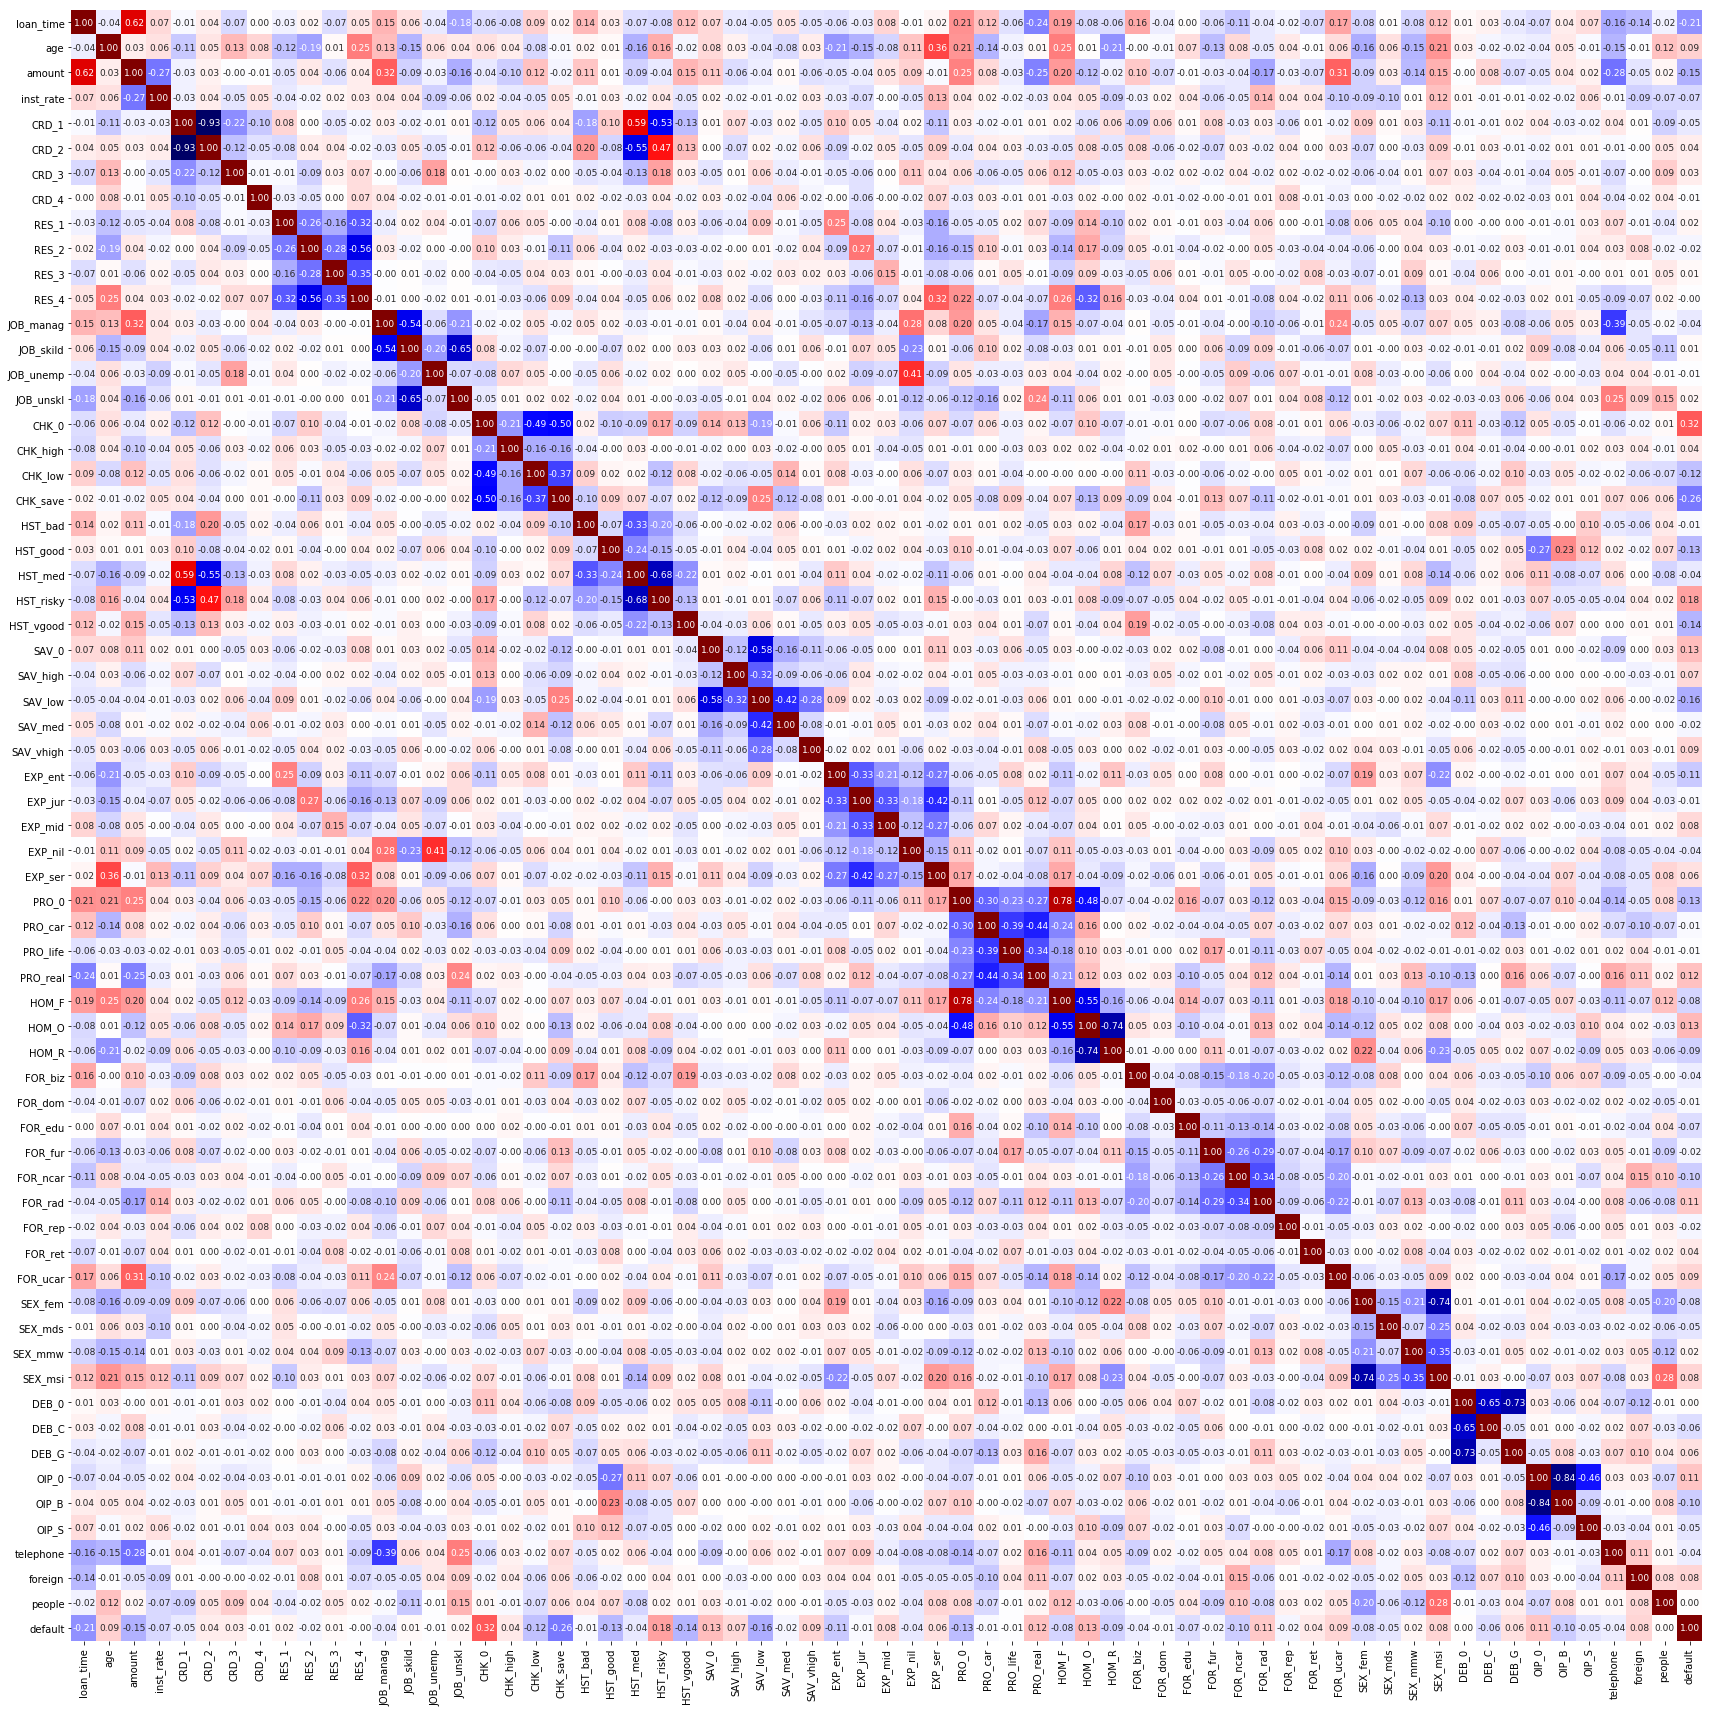

In [176]:
dicts = [{4:4,1:1,2:2,3:3}, # ..................................................................................................................................n_credits
         {2:2,4:4,3:3,1:1}, # ..................................................................................................................................residence
         {'man/self-em/HQ/off':'manag','unemp / unskill (non-res)':'unemp','skilled / official':'skild','unskilled (resident)':'unskl'}, # .....................job
         {'< 0':'save','0 to 200':'low','> 201':'high','none':0}, # ............................................................................................checking
         {'fully repaid':'vgood','fully repaid here':'good','repaid':'med','delayed':'bad','critical':'risky'}, # ..............................................history
         {'<100':'low','101 to 500':'med','unk_nil':0,'501 to 1000':'high','>1000':'vhigh'}, # .................................................................savings
         {'less than 1':'ent','unemployed':'nil','1 to less than 4':'jur','more than 7':'ser','4 to less than 7':'mid'}, # .....................................job_status
         {'UNK/None':0,'Car/Other':'car','BSSA/Life':'life','real estate':'real'}, # ...........................................................................property
         {'own':'O','free':'F','rent':'R'}, # ..................................................................................................................housing
         {'edu':'edu','car_new':'ncar','repairs':'rep','business':'biz','dom_app':'dom','fur_equ':'fur','rad_tel':'rad','car_used':'ucar','retain':'ret'}, # ...for
         {'male_ds':'mds','female':'fem','male_mw':'mmw','male_single':'msi'}, # ...............................................................................sex
         {'coapplicant':'C','none':0,'guarantor':'G'}, # .......................................................................................................debtor
         {'none':0,'bank':'B','stores':'S'}] # .................................................................................................................OIP

hot_encode_these = ['n_credits','residence','job','checking','history','savings','job_status','property','housing','for','sex','debtor','OIP']

CA_he = pd.DataFrame(columns=hot_encode_these)

for n,col in enumerate(hot_encode_these):
    CA_he[col]= raw[col].map(dicts[n])

prefs = ['CRD','RES','JOB','CHK','HST','SAV','EXP','PRO','HOM','FOR','SEX','DEB','OIP']

CA_he = pd.get_dummies(CA_he,columns=hot_encode_these[0:15], prefix=prefs, drop_first=False)

NU_he = raw[['loan_time','age','amount','inst_rate']]

BI_he = raw[['telephone','foreign','people']]

ohe_data = pd.concat([NU_he, CA_he, BI_he], axis=1)

#print feature_names


data = pd.concat([ohe_data, pd.DataFrame(data=y,columns=['default'])], axis=1)
n = 30
fig = plt.figure(figsize=[n,n])
corr_plot = sns.heatmap(data.corr(), annot=True, fmt=".2f", square=True, cmap='seismic', cbar=False,annot_kws={"size": 9},vmin=-1,vmax=1)
plt.show()
fig.savefig('foo.png')

#data.drop(['CRD_1','CRD_2','CRD_3','CRD_4',
#           'PPL_1','PPL_2',
#           'INR_1','INR_2','INR_3','INR_4',
#           'RES_1','RES_2','RES_3','RES_4',
#           'JOB_manag','JOB_skild','JOB_unemp','JOB_unskl',
#           'DEB_0','DEB_C','DEB_G',
#           'SEX_mds','SEX_mmw','SEX_msi',
#           'HST_vgood','HST_good','HST_med','HST_bad',
#           'SAV_high','SAV_med','SAV_vhigh','SAV_0',
#           'EXP_mid','EXP_ser',
#           'PRO_0','PRO_car','PRO_life',
#           'foreign','CHK_0','HOM_O','FOR_rad','telephone'], axis = 1, inplace = True)

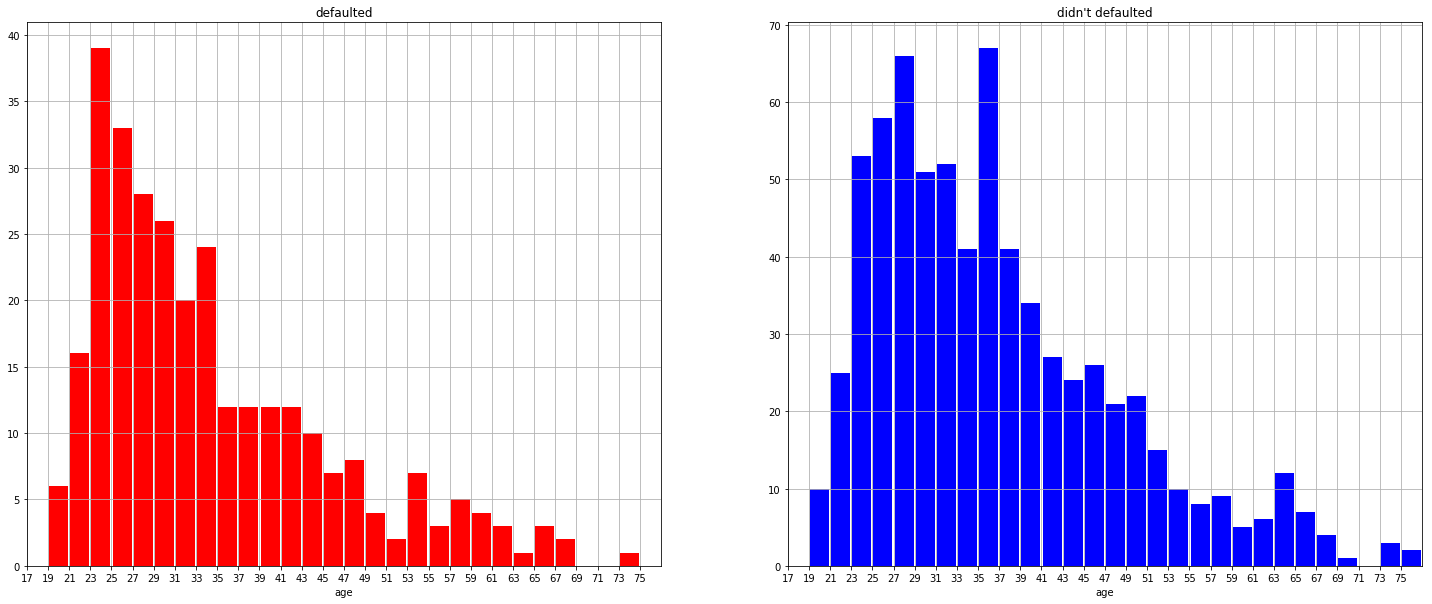

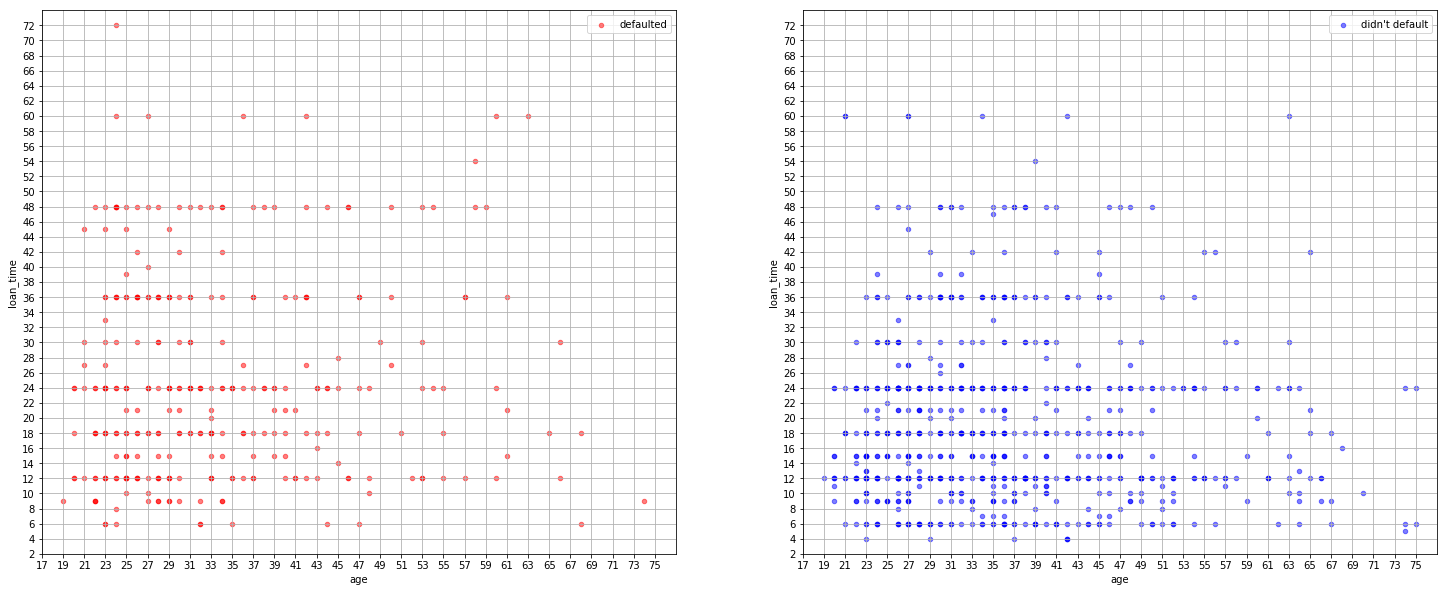

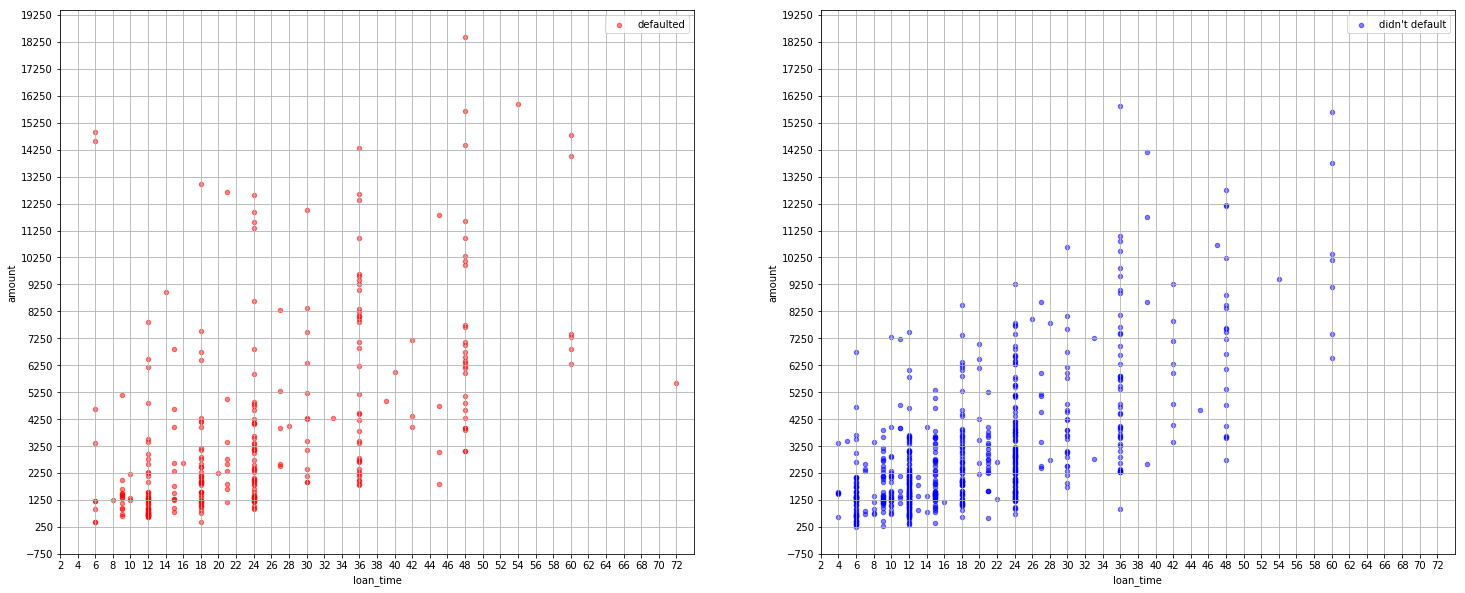

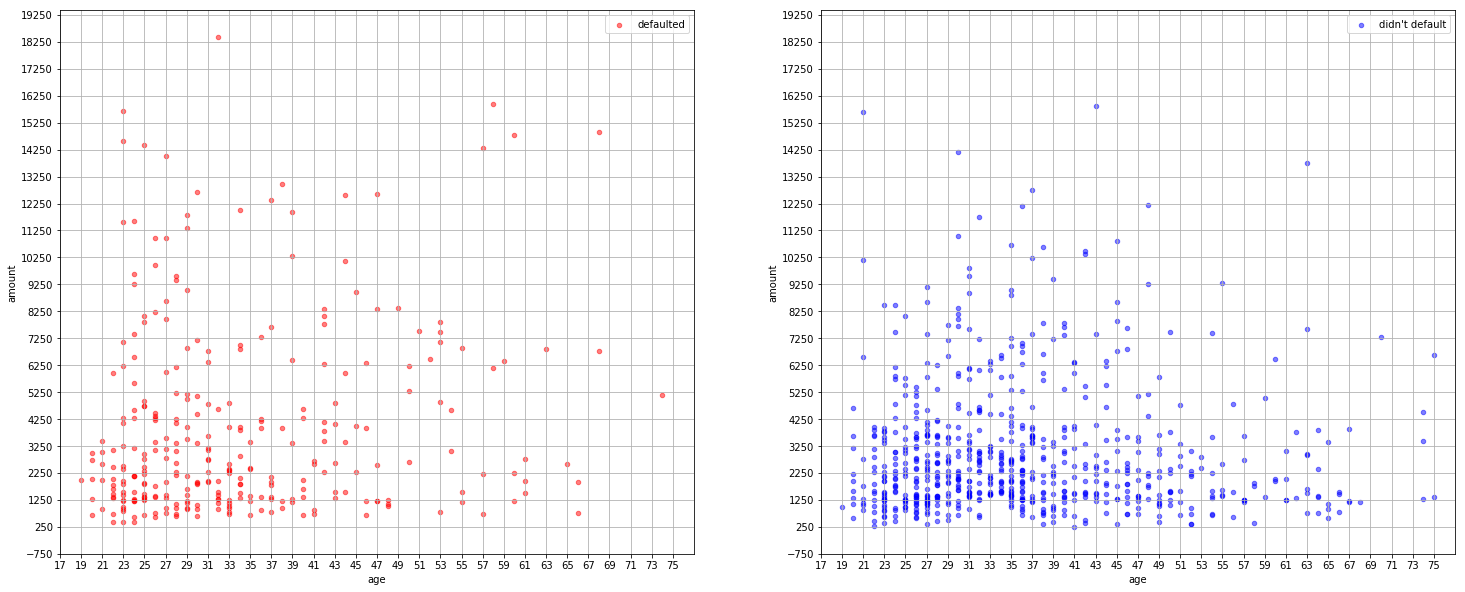

In [199]:
def scatter_plot(data,y_name,x_name,ydiv,xdiv,size,a):
    ylims = [min(data.loc[:,y_name].values)-ydiv, max(data.loc[:,y_name].values)+ydiv]
    xlims = [min(data.loc[:,x_name].values)-xdiv, max(data.loc[:,x_name].values)+xdiv]
    fig = plt.figure(figsize=[25,10])
    
    ax1 = fig.add_subplot(121); plt.xlabel(x_name); plt.ylabel(y_name)
    plt.xticks(np.arange(xlims[0],xlims[1],xdiv)); plt.xlim((xlims[0],xlims[1])); 
    plt.yticks(np.arange(ylims[0],ylims[1],ydiv)); plt.ylim((ylims[0],ylims[1])); 
    y0 = data[data['default']==1].loc[:,y_name].values
    x = data[data['default']==1].loc[:,x_name].values
    ax1.scatter(x,y0,c='r',marker='o',s=size,alpha=a,label='defaulted')
    ax1.grid(True); ax1.legend(loc='best')

    ax2 = fig.add_subplot(122); plt.xlabel(x_name); plt.ylabel(y_name)
    plt.xticks(np.arange(xlims[0],xlims[1],xdiv)); plt.xlim((xlims[0],xlims[1])); 
    plt.yticks(np.arange(ylims[0],ylims[1],ydiv)); plt.ylim((ylims[0],ylims[1]));
    y0 = data[data['default']==2].loc[:,y_name].values
    x = data[data['default']==2].loc[:,x_name].values
    ax2.scatter(x,y0,c='b',marker='o',s=size,alpha=a,label="didn't default")
    ax2.grid(True); ax2.legend(loc='best')
    return plt.show()

def hist_plot(data,name,xdiv,ydiv,ymax):
    
    xlims = [min(data.loc[:,name].values)-xdiv, max(data.loc[:,name].values)+xdiv]
    bins = range(xlims[0],xlims[1]+xdiv,xdiv)
    fig = plt.figure(figsize=[25,10])
    
    ax1 = fig.add_subplot(121); plt.xlabel(name); plt.title('defaulted')
    plt.xticks(np.arange(xlims[0],xlims[1],xdiv)); plt.xlim((xlims[0],xlims[1]));  
    pop = data[data['default']==1].loc[:,name].values
    ax1.hist(pop, bins, color='r', rwidth=0.9);ax1.grid(True)
    
    ax2 = fig.add_subplot(122); plt.xlabel(name); plt.title("didn't defaulted")
    plt.xticks(np.arange(xlims[0],xlims[1],xdiv)); plt.xlim((xlims[0],xlims[1]));
    pop = data[data['default']==2].loc[:,name].values
    ax2.hist(pop, bins, color='b', rwidth=0.9);ax2.grid(True)
    return plt.show()

hist_plot(raw,'age',2)

scatter_plot(raw,'loan_time','age',2,2,20,0.5)
scatter_plot(raw,'amount','loan_time',1000,2,20,0.5)
scatter_plot(raw,'amount','age',1000,2,20,0.5)

64


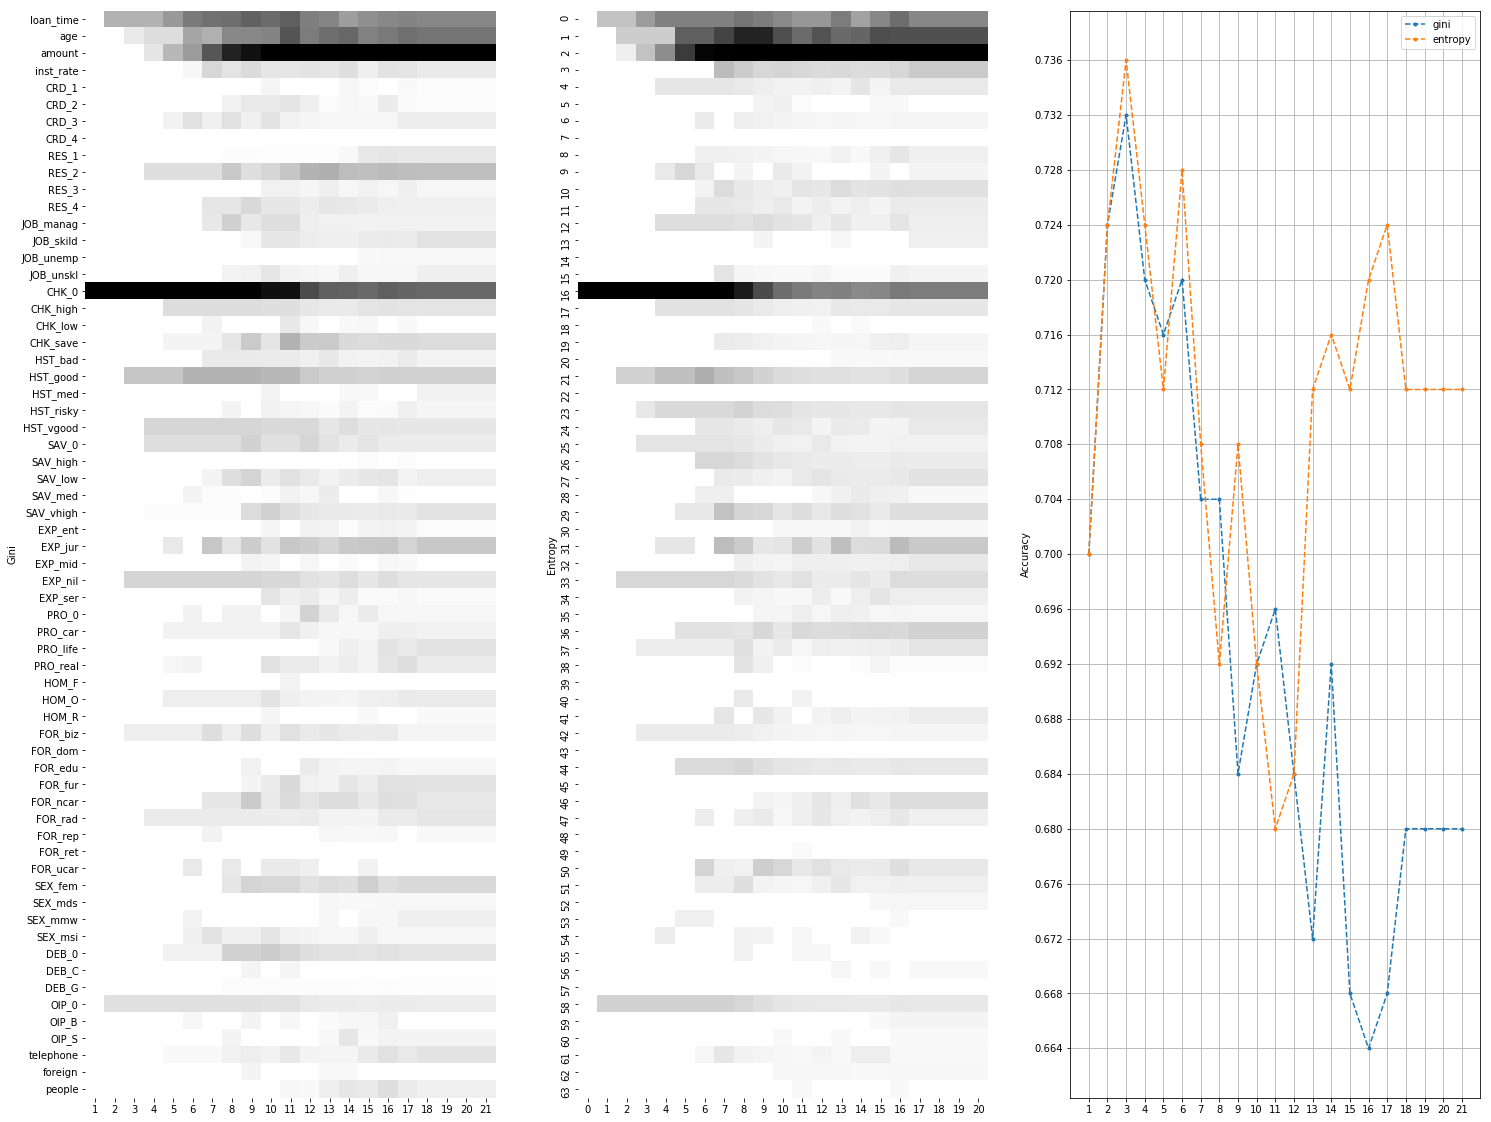

RFC (750L, 43L) 0.7 [ 0  1  2  3  4  5  8  9 10 11 12 13 15 16 18 19 20 21 22 23 25 27 30 31 32
 34 35 36 37 38 40 41 45 46 47 51 54 55 58 59 60 61 63]
GBC (750L, 42L) 0.784 [ 0  1  2  3  4  8  9 12 16 17 18 19 20 21 22 23 24 25 27 29 30 32 33 35 36
 38 40 41 42 44 46 47 50 51 52 55 56 57 58 59 60 62]
ADA (750L, 26L) 0.744 [ 0  1  2  3  4  8  9 16 17 19 21 23 25 30 32 38 40 46 47 48 50 52 54 57 58
 62]
LRC (750L, 64L) 0.736 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49
 50 51 52 53 54 55 56 57 58 59 60 61 62 63]
VEC (750L, 64L) 0.736 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49
 50 51 52 53 54 55 56 57 58 59 60 61 62 63]
DTC (750L, 5L) 0.648 [ 0  1  2  3 16]


In [158]:
from sklearn.feature_selection import RFECV
from sklearn.feature_selection import SelectFromModel

X = ohe_data.values
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=2017)
feature_names = ohe_data.columns.values
print len(feature_names)
#######################################
# Stand Alone DT max_depth assessment
#######################################
fig = plt.figure(figsize=[25,20]); max_depth = 22
ax1 = fig.add_subplot(133);plt.ylabel("Accuracy"); plt.yticks(np.arange(0.66,0.80,0.004)); plt.xticks(np.arange(1,max_depth,1))
ax2 = fig.add_subplot(131); ax3 = fig.add_subplot(132)
for criteria in ('gini','entropy'):
    test_accuracy = []; imps = []
    for depth in range(1,max_depth):
        tree = DecisionTreeClassifier(max_depth=depth, criterion=criteria, random_state=2017).fit(X_train,y_train); test_accuracy.append(tree.score(X_test, y_test))
        fea = tree.feature_importances_.tolist(); max0 = max(fea); min0 = min(fea); fea = list(map((lambda x: (x-min0)/(max0-min0)),fea)); imps.append(fea)
    fea_imp = pd.DataFrame(data=imps, columns=feature_names, index=range(1,max_depth))
    c = 'binary'
    if criteria=='gini':
        sns.heatmap(fea_imp.T, annot=False, fmt=".2f", square=False, cmap=c,ax=ax2, cbar=False,annot_kws={"size": 8})
    else:
        sns.heatmap(fea_imp.T.values, annot=False, fmt=".2f", square=False, cmap=c,ax=ax3, cbar=False,annot_kws={"size": 8})
    ax1.plot(range(1,max_depth),test_accuracy,'--.',label=criteria)
ax1.grid(True); ax1.legend(loc='best'); ax2.set_ylabel('Gini'); ax3.set_ylabel('Entropy'); plt.show()

RFC = RandomForestClassifier(max_features='sqrt', bootstrap=False,random_state=2017)
GBC = GradientBoostingClassifier(max_features=None,random_state=2017)
ADA = AdaBoostClassifier(random_state=2017)
BGC = BaggingClassifier(random_state=2017)
LRC = LogisticRegression(solver='liblinear',random_state=2017, max_iter=1000)
VEC = LinearSVC(dual=False,random_state=2017)
DTC = DecisionTreeClassifier(random_state=2017)
models = [RFC,GBC,ADA,BGC,LRC,VEC,DTC]
model_names = ['RFC','GBC','ADA','BGC','LRC','VEC','DTC']

skf = StratifiedKFold(n_splits=8, random_state=2017)

for count, model in enumerate(models):
    if count !=3:
        f = RFECV(model, n_jobs=8, cv=skf, scoring='roc_auc').fit(X_train, y_train)
        t = f.transform(X_train)
        print model_names[count],
        print t.shape,
        print f.score(X_test,y_test),
        print f.get_support(indices=True)

In [18]:
a =range(0,5); print a; print a[::-1]
print np.concatenate([a,a[::-1]])

[0, 1, 2, 3, 4]
[4, 3, 2, 1, 0]
[0 1 2 3 4 4 3 2 1 0]


In [ ]:
print '>>> y_test'
print pd.Series(y_test).value_counts();print
print '>>> y_train'
print pd.Series(y_train).value_counts();print
print '>>> y'
print raw['default'].value_counts()